# Segmentez des clients d'un site e-commerce

## Librairie nécessaire pour le travail

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, fcluster
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.metrics import adjusted_rand_score
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py

## Importtion des données

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [4]:
data_olist = pd.read_csv("/home/sacko/Documents/Customer/Donnees/data_modelisation.csv")
data_olist.drop(["Unnamed: 0"], axis=1, inplace = True)
data_olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114859 entries, 0 to 114858
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      114859 non-null  object 
 1   order_id                       114859 non-null  object 
 2   review_score                   114859 non-null  int64  
 3   review_comment_title           13584 non-null   object 
 4   review_comment_message         48092 non-null   object 
 5   review_creation_date           114859 non-null  object 
 6   review_answer_timestamp        114859 non-null  object 
 7   order_item_id                  114859 non-null  float64
 8   product_id                     114859 non-null  object 
 9   seller_id                      114859 non-null  object 
 10  price                          114859 non-null  float64
 11  freight_value                  114859 non-null  float64
 12  customer_id                   

## Suppression des variables unitiles

In [5]:
data_olist.drop(["review_id", "review_comment_title", "review_creation_date", "review_answer_timestamp", 
                 "order_item_id", "product_id", "seller_id", "freight_value",
                "order_delivered_customer_date", "customer_zip_code_prefix", "customer_state", "product_category_name",
                "product_name_lenght", "product_description_lenght", "payment_sequential", "payment_type"], axis = 1, inplace = True)

## Information sur la structure des données

In [6]:
data_olist.info()
print("\n")
print("Ona dans notre bse de données 114859 observation et 12 descripteurs")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114859 entries, 0 to 114858
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  114859 non-null  object 
 1   review_score              114859 non-null  int64  
 2   review_comment_message    48092 non-null   object 
 3   price                     114859 non-null  float64
 4   customer_id               114859 non-null  object 
 5   order_status              114859 non-null  object 
 6   order_purchase_timestamp  114859 non-null  object 
 7   customer_unique_id        114859 non-null  object 
 8   customer_city             114859 non-null  object 
 9   product_photos_qty        113233 non-null  float64
 10  payment_installments      114859 non-null  int64  
 11  payment_value             114859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 10.5+ MB


Ona dans notre bse de données 114859 obs

## Suppression des valeurs manquantes

In [7]:
def imputation(data_olist):
    return data_olist.dropna(axis=0)

In [8]:
df_clean = imputation(data_olist)

In [9]:
df_clean.shape

(47375, 12)

## Statistiques descriptives

In [10]:
df_clean.describe().T

count        mean         std   min     25%     50%  \
review_score          47375.0    3.643166    1.614782  1.00   2.000    4.00   
price                 47375.0  124.153165  190.926729  0.85  39.990   75.90   
product_photos_qty    47375.0    2.198734    1.712699  1.00   1.000    1.00   
payment_installments  47375.0    3.112317    2.901790  1.00   1.000    2.00   
payment_value         47375.0  186.897881  309.474767  0.00  64.915  116.45   

                         75%       max  
review_score            5.00      5.00  
price                 136.90   6735.00  
product_photos_qty      3.00     19.00  
payment_installments    4.00     24.00  
payment_value         203.33  13664.08

## SEGMENTATION RFM
Dns cette partie nous allons effectuer l'analyse RFM (Recency, Frequency, Monetary) sur le DataFrame nettoyé df_clen. Il regroupe les données par «ID client» et calcule trois métriques pour chaque client :
Récence : Le nombre de jours depuis le dernier achat du client. 
Fréquence : Le nombre d'achat associés à chaque client.
Monétaire : le montant total dépensé par chaque client.

In [11]:
# Recherche de la date la plus ancienne
ancien = df_clean["order_purchase_timestamp"].min()
ancien

'2016-10-03 09:44:50'

In [12]:
# Recherche de la date la plus recente
recent = df_clean["order_purchase_timestamp"].max()
recent

'2018-08-29 14:18:28'

In [13]:
import datetime as dt
aammjj = str.split(str.split(recent)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]) + 1)

In [14]:
NOW

datetime.datetime(2018, 8, 30, 0, 0)

In [15]:
# Changement de type "order_purchase_timestamp" à datetime
df_clean["order_purchase_timestamp"] = pd.to_datetime(df_clean["order_purchase_timestamp"])

/tmp/ipykernel_4328/1496538611.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
df_rfm = df_clean.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "customer_unique_id": lambda x: len(x),
                 "payment_value": lambda x: sum(x)})



In [17]:
df_rfm['order_purchase_timestamp'] = df_rfm['order_purchase_timestamp'].astype(int)

df_rfm.rename(columns={'order_purchase_timestamp': 'recency',
                         'customer_unique_id': 'frequency',
                         'payment_value': 'monetary_value'}, inplace=True)
df_rfm.head()

recency  frequency  monetary_value
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2      111          1          141.90
0000f6ccb0745a6a4b88665a16c9f078      321          1           43.62
00053a61a98854899e70ed204dd4bafe      182          2          838.36
0005ef4cd20d2893f0d9fbd94d3c0d97      170          1          129.76
0006fdc98a402fceb4eb0ee528f6a8d4      407          1           29.00

In [18]:
# Calcul du score de récence en fonction des quantiles, en attribuant des étiquettes de 1 à 5 (1 étant la récence la plus basse)
df_rfm["recency_score"] = pd.qcut(df_rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    
# Calcul du score de fréquence en fonction des quantiles de rang, en attribuant des étiquettes de 1 à 5 (1 étant la fréquence la plus basse)
df_rfm["frequency_score"] = pd.qcut(df_rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [19]:
df_rfm.frequency_score.unique()

[1, 5, 2, 3, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [20]:
df_rfm.recency_score.unique()

[4, 2, 3, 1, 5]
Categories (5, int64): [5 < 4 < 3 < 2 < 1]

In [21]:
df_rfm['segment'] = df_rfm['recency_score'].astype(str) + df_rfm['frequency_score'].astype(str)
df_rfm.head()

recency  frequency  monetary_value  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      111          1          141.90   
0000f6ccb0745a6a4b88665a16c9f078      321          1           43.62   
00053a61a98854899e70ed204dd4bafe      182          2          838.36   
0005ef4cd20d2893f0d9fbd94d3c0d97      170          1          129.76   
0006fdc98a402fceb4eb0ee528f6a8d4      407          1           29.00   

                                 recency_score frequency_score segment  
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2             4               1      41  
0000f6ccb0745a6a4b88665a16c9f078             2               1      21  
00053a61a98854899e70ed204dd4bafe             3               5      35  
0005ef4cd20d2893f0d9fbd94d3c0d97             4               1      41  
0006fdc98a402fceb4eb0ee528f6a8d4             1               1      11

In [22]:
seg_map = {
r'[1-2][1-2]': 'Clients_presque_perdus',
r'[1-2][3-4]': 'clients_perdus',
r'[1-2]5': 'clients_à_réactiver',
r'3[1-2]': 'clients_à_pas_perdre',
r'33': 'clients_risqués',
r'[3-4][4-5]': 'clients_promoteurs',
r'41': 'nouveux_clients',
r'51': 'clients_fidèls',
r'[4-5][2-3]': 'clients_à_surveiller',
r'5[4-5]': 'champions'
}

In [23]:
# Mappeage des segments RFM aux segments clients correspondants à l'aide de seg_map prédéfini
df_rfm['segment'] = df_rfm['segment'].replace(seg_map, regex=True)

# Conservez uniquement les colonnes pertinentes et renvoyez la trame de données résultante
df_rfm = df_rfm[["recency", "frequency", "monetary_value", "segment"]]

#df_rfm.index = df_rfm.index.astype(int)  # Convert index to integer
df_rfm.head()

recency  frequency  monetary_value  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      111          1          141.90   
0000f6ccb0745a6a4b88665a16c9f078      321          1           43.62   
00053a61a98854899e70ed204dd4bafe      182          2          838.36   
0005ef4cd20d2893f0d9fbd94d3c0d97      170          1          129.76   
0006fdc98a402fceb4eb0ee528f6a8d4      407          1           29.00   

                                                 segment  
customer_unique_id                                        
0000366f3b9a7992bf8c76cfdf3221e2         nouveux_clients  
0000f6ccb0745a6a4b88665a16c9f078  Clients_presque_perdus  
00053a61a98854899e70ed204dd4bafe      clients_promoteurs  
0005ef4cd20d2893f0d9fbd94d3c0d97         nouveux_clients  
0006fdc98a402fceb4eb0ee528f6a8d4  Clients_presque_perdus

## La grille illustrative de RFM

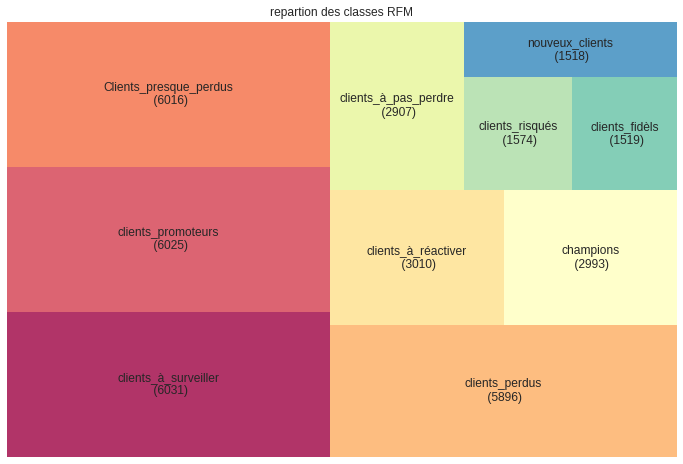

In [24]:
import squarify
note_pie = df_rfm.segment.value_counts()
labels = note_pie.index
labels = []
for i in range(0,len(note_pie)):
    labels.append(f"{note_pie.index[i]}\n ({note_pie[i]})")
    
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=note_pie, label=labels, alpha=.8, color=colors)
plt.axis('off')
plt.title('repartion des classes RFM')
plt.savefig('P2_02_Treemap_RFM.jpg')
plt.show()

La grille RFM illustrée ci-dessus représente une pratique standard adoptée par la plupart des entreprises pour définir leur clientèle. Par la suite, il contribue à la planification stratégique de campagnes ciblées visant à impliquer efficacement chaque segment. En analysant la récence, la fréquence et la valeur monétaire des transactions clients, les organisations obtiennent des informations précieuses qui leur permettent d'adapter leurs initiatives marketing aux préférences et aux besoins de segments de clientèle distincts. Cette approche favorise un engagement et une fidélité accrus des clients, contribuant ainsi au succès global de l'entreprise.

In [99]:
# Obtenez les 10 produits les plus préférés
segments = df_rfm['segment'].value_counts()

# Bar plot
fig = px.bar(x=segments.index,
             y=segments.values,
             color=segments.index,
             text=segments.values,
             title="RFM Segments",
             labels={'x': 'Product', 'y': 'Count'})

# Mettre à jour la mise en page pour une meilleure apparence
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)

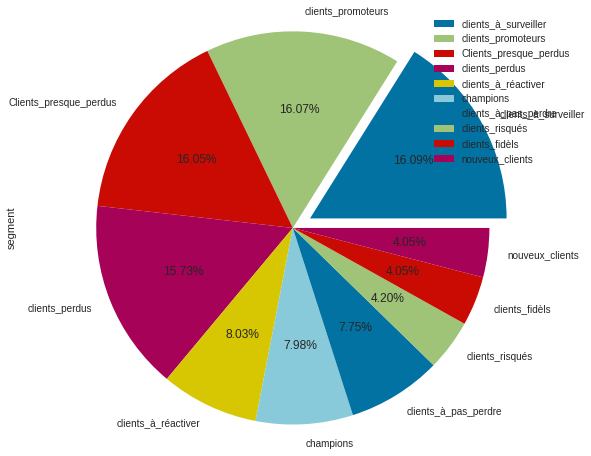

In [26]:
plt.figure(figsize = (10, 8), )
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

segments.plot(kind = 'pie',
            explode = explode,
            autopct = '%1.2f%%')
plt.axis('equal')
plt.legend(labels = segments.index, loc = "best")
plt.show()

In [367]:
df_rfm[["segment","recency", "frequency", "monetary_value"]].groupby("segment").agg(["mean", "count"])

recency       frequency       monetary_value      
                              mean count      mean count           mean count
segment                                                                      
Clients_presque_perdus  400.325964  6016  1.000000  6016     161.987035  6016
champions                48.575677  2993  1.641831  2993     363.060418  2993
clients_fidèls           48.545095  1519  1.000000  1519     161.661600  1519
clients_perdus          401.289349  5896  1.000000  5896     158.029042  5896
clients_promoteurs      181.646307  6025  1.657593  6025     345.973021  6025
clients_risqués         224.459339  1574  1.000000  1574     139.963139  1574
clients_à_pas_perdre    223.944272  2907  1.000000  2907     156.161968  2907
clients_à_réactiver     395.958472  3010  2.329900  3010     536.412000  3010
clients_à_surveiller     93.618803  6031  1.000000  6031     165.221512  6031
nouveux_clients         140.889987  1518  1.000000  1518     162.072971  1518

## Évaluons les résultats de la segmentation RFM

Nous avons segmenté la clientèle en fonction de la récence, de la fréquence et de la valeur monétaire, ce qui indique une approche stratégique pour comprendre et gérer les relations clients.
Nous pouvons identifier la particularité de nous différents clients en fonction d leurs comportements d'achats sur chaque segment.
Analysons par exemple le segment "clients_à_réactiver", se distingue comme ayant la valeur monétaire totale la plus élevée (536.412000$), ce qui indique qu'une partie importante des revenus de l'entreprise provient des clients de ce segment. 
Cependant, il est important de noter que le segment "clients_à_réactiver" présente également la récence moyenne très élevée (395.958472 jours), ce qui suggère une baisse potentielle de l'engagement ou de la fidélité de ces clients.
On quand même affirmer que le e succès de l’entreprise à générer des revenus à partir de ce segment démontre sa capacité à capitaliser sur les relations clients existantes et à générer des ventes.

En somme nous pouvons dire qu'il est très appréciable de voir une entreprise générer des revenus et mettre en place une approche structurée de la clientèle, mais ils est obligatoire pour toute entreprise souciée de maximiser et garantir ses actifs, d'avoir une capacité d'engager et à fidéliser efficacement les clients dans tous les segments car son succès peut être mesuré non seulement par la génération de revenus, mais également par des facteurs tels que la satisfaction client, les taux de fidélisation et la valeur client à long terme.

## SEGMENTATION PAR K-MEANS

### Construction d'une base à partir des variables de RFM

In [48]:
df1= df_rfm[["recency", "frequency", "monetary_value"]]

df2 = df_clean[["customer_unique_id", "review_score", "payment_installments", "review_comment_message"]]

df_kmean = df1.merge(df2, on = "customer_unique_id")

df_kmean.duplicated(["customer_unique_id"]).sum()

9886

In [49]:
df_kmean= df_kmean.drop_duplicates(["customer_unique_id"])

In [50]:
df_kmean.duplicated(["customer_unique_id"]).sum()

0

In [51]:
df_kmean= df_kmean.drop_duplicates(["customer_unique_id"])
df_kmean.head()

customer_unique_id  recency  frequency  monetary_value  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1          141.90   
1  0000f6ccb0745a6a4b88665a16c9f078      321          1           43.62   
2  00053a61a98854899e70ed204dd4bafe      182          2          838.36   
4  0005ef4cd20d2893f0d9fbd94d3c0d97      170          1          129.76   
5  0006fdc98a402fceb4eb0ee528f6a8d4      407          1           29.00   

   review_score  payment_installments  \
0             5                     8   
1             4                     4   
2             1                     3   
4             1                     4   
5             3                     2   

                              review_comment_message  
0  Adorei a cortina, ficou linda na minha sala, e...  
1                                       Bom vendedor  
2  Olá! Comprei dois potes de whey e chegou apena...  
4  Até o presente momento não recebi o produto e ...  
5    só achei que a altura da saia poderia ser maior

## Selection des variables pour la segmentation par kmeans

In [52]:
df_kmeans= df_kmean[["customer_unique_id", "recency", "frequency", "monetary_value","review_score", "payment_installments"]] 

## Normalisation des données

In [53]:
numerical_features = list(df_kmeans.select_dtypes(include="number").columns)
numerical_features

['recency',
 'frequency',
 'monetary_value',
 'review_score',
 'payment_installments']

In [54]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

## Sélection du nombre de clusters

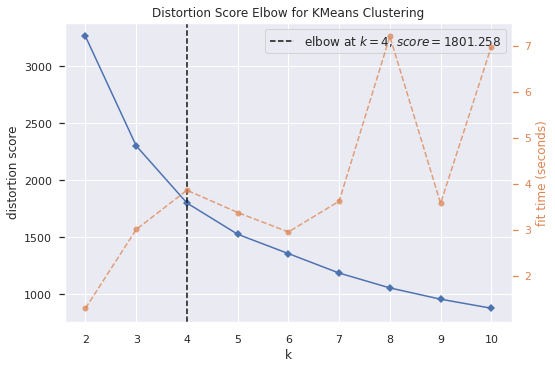

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
X = df_kmeans.copy()
# Méthode du coude
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

## Distances intercluster

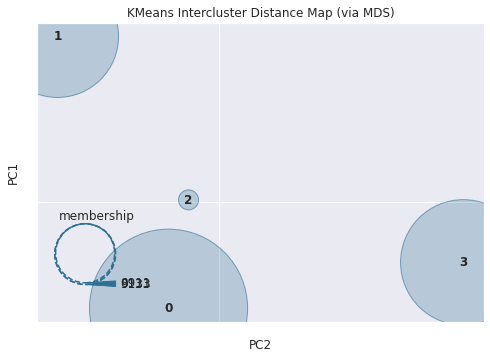

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [56]:
# Carte de distance intercluster avec le meilleur k
k=4
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(k)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()


## Modèle KMens avec K optimal

In [57]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(4))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
df_kmeans["kmeans_label"] = kmeans_labels
df_kmeans.head()

customer_unique_id  recency  frequency  monetary_value  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1          141.90   
1  0000f6ccb0745a6a4b88665a16c9f078      321          1           43.62   
2  00053a61a98854899e70ed204dd4bafe      182          2          838.36   
4  0005ef4cd20d2893f0d9fbd94d3c0d97      170          1          129.76   
5  0006fdc98a402fceb4eb0ee528f6a8d4      407          1           29.00   

   review_score  payment_installments  kmeans_label  
0             5                     8             1  
1             4                     4             3  
2             1                     3             0  
4             1                     4             0  
5             3                     2             3

In [58]:
KM_clust_sizes = df_kmeans.groupby('kmeans_label').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

KM_size
kmeans_label         
0                8911
1               12409
2                9124
3                7045

## Visualisation du nombre de clusters de k-means

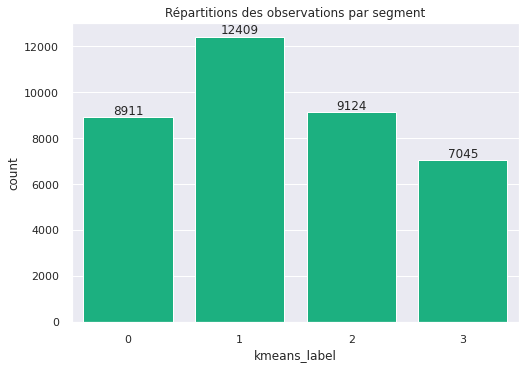

In [59]:
sns.set()
ax = sns.countplot(x="kmeans_label", data=df_kmeans, color="#03C988")
for container in ax.containers:
    ax.bar_label(container)

_ = ax.set_title("Répartitions des observations par segment")

## Analyse des moyennes de clusters

In [60]:
data_segm_analysis = df_kmeans[["kmeans_label","recency", "frequency", "monetary_value"]].groupby("kmeans_label").agg(["mean"])
data_segm_analysis

recency frequency monetary_value
                    mean      mean           mean
kmeans_label                                     
0             235.399282  1.440691     336.053069
1             141.669595  1.180434     193.460573
2             427.167690  1.212078     207.569106
3             185.867424  1.253371     222.172528

In [61]:
data_segm_analysis.rename({0:'clients_à_réactiver', 
                         1:'nouveaux_clients', 
                         2: 'clients_perdus', 
                         3:'clients_promoteurs'})

recency frequency monetary_value
                           mean      mean           mean
kmeans_label                                            
clients_à_réactiver  235.399282  1.440691     336.053069
nouveaux_clients     141.669595  1.180434     193.460573
clients_perdus       427.167690  1.212078     207.569106
clients_promoteurs   185.867424  1.253371     222.172528

## SEGMENTATION PAR DBSCAN

In [62]:
from sklearn.neighbors import NearestNeighbors
from kneebow.rotor import Rotor

In [63]:
df_dbs=df_kmean[["recency", "frequency", "monetary_value", "payment_installments", "review_score"]]

In [64]:
df_dbs.head()

recency  frequency  monetary_value  payment_installments  review_score
0      111          1          141.90                     8             5
1      321          1           43.62                     4             4
2      182          2          838.36                     3             1
4      170          1          129.76                     4             1
5      407          1           29.00                     2             3

In [65]:
scaler = StandardScaler()
df_dbs_scaled = scaler.fit_transform(df_dbs)

In [66]:
dbs = DBSCAN()

model = dbs.fit(df_dbs_scaled)

df_dbs['Segments'] = model.fit_predict(df_dbs_scaled)

/tmp/ipykernel_4328/959641675.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



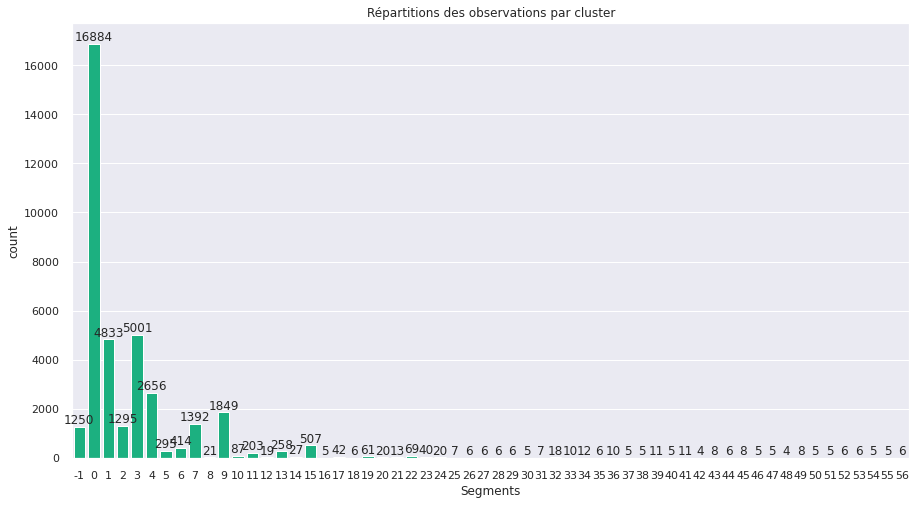

In [67]:
# Visualisation du nombre de clusters
sns.set()
plt.rcParams["figure.figsize"] = (15, 8)
ax = sns.countplot(x='Segments', data=df_dbs, color="#03C988")
for container in ax.containers:
    ax.bar_label(container)
_ = ax.set_title('Répartitions des observations par cluster')

On remarque un nombre important de segments ainsi qu'un manque de parité entre eux. Cela nécessite une réduction de nombre de segments. 

In [71]:
# Score silhouette
#print(f"Le score silhoutte est {round(metrics.silhouette_score(df_dbs, df_dbs['Segments']), 3)}")

## Recherche d'epsilon optimal

In [72]:
rfm_DBscan = df_dbs
scaler = StandardScaler()
rfm_DBscan_scaleed = scaler.fit_transform(rfm_DBscan)

# Création d'un modèle K-neighbors avec 2 pour trouver le meilleur Epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(rfm_DBscan_scaleed)

# Pour chaque point, calcul la distance de ses voisins
distances, indices = nbrs.kneighbors(rfm_DBscan_scaleed)

Text(0, 0.5, 'Epsilon')

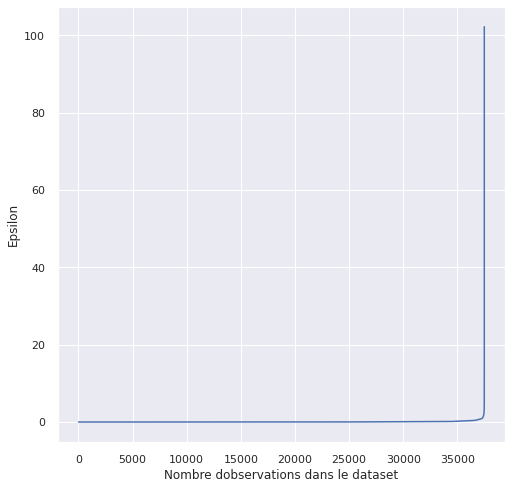

In [73]:
# Trie et affichage des résultats
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(8, 8))
plt.plot(distances)
plt.xlabel('Nombre d''observations dans le dataset')
plt.ylabel('Epsilon')

## Création du modèle avec min_samples = 500 et eps=0,5

In [74]:
dbs_tuned = DBSCAN(min_samples=500, eps=0.5)

model = dbs_tuned.fit(rfm_DBscan_scaleed)

rfm_DBscan['Segments'] = model.fit_predict(rfm_DBscan_scaleed)

/tmp/ipykernel_4328/702121711.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
labels = model.labels_

In [76]:
np.unique(labels)

array([-1,  0,  1,  2,  3])

In [77]:
df_segm_analysis = rfm_DBscan.groupby(['Segments']).mean() 
df_segm_analysis.head()

recency  frequency  monetary_value  payment_installments  \
Segments                                                                
-1        268.725760   1.645048      410.114762              4.692679   
 0        234.890103   1.000000      118.363917              2.115601   
 1        211.763505   1.000000      107.048671              1.487751   
 2        190.765596   1.000000      117.334256              1.648240   
 3        196.842149   1.000000      105.711175              1.436608   

          review_score  
Segments                
-1            3.201683  
 0            5.000000  
 1            4.000000  
 2            1.000000  
 3            3.000000

In [78]:
DBSCAN_sizes = rfm_DBscan.groupby('Segments').size().to_frame()
DBSCAN_sizes.columns = ["DBSCAN_size"]
DBSCAN_sizes

DBSCAN_size
Segments             
-1              15326
 0              14550
 1               3184
 2               3238
 3               1191

### Visualisation du nombre de clusters DBSCAN

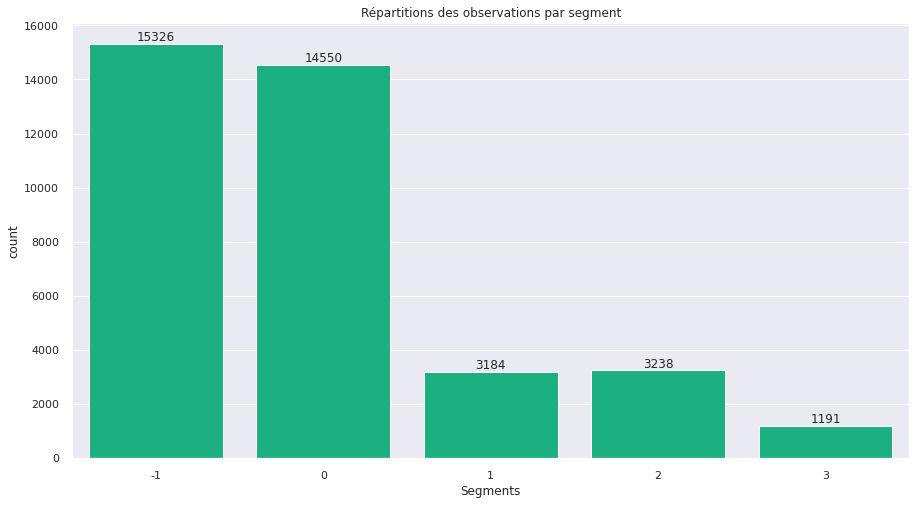

In [79]:
#Nombre de clients par segment
sns.set()
ax = sns.countplot(x="Segments", data=rfm_DBscan, color="#03C988")
for container in ax.containers:
    ax.bar_label(container)

_ = ax.set_title("Répartitions des observations par segment")

## La grille illustrative de DBSCAN

<AxesSubplot:ylabel='Segments'>

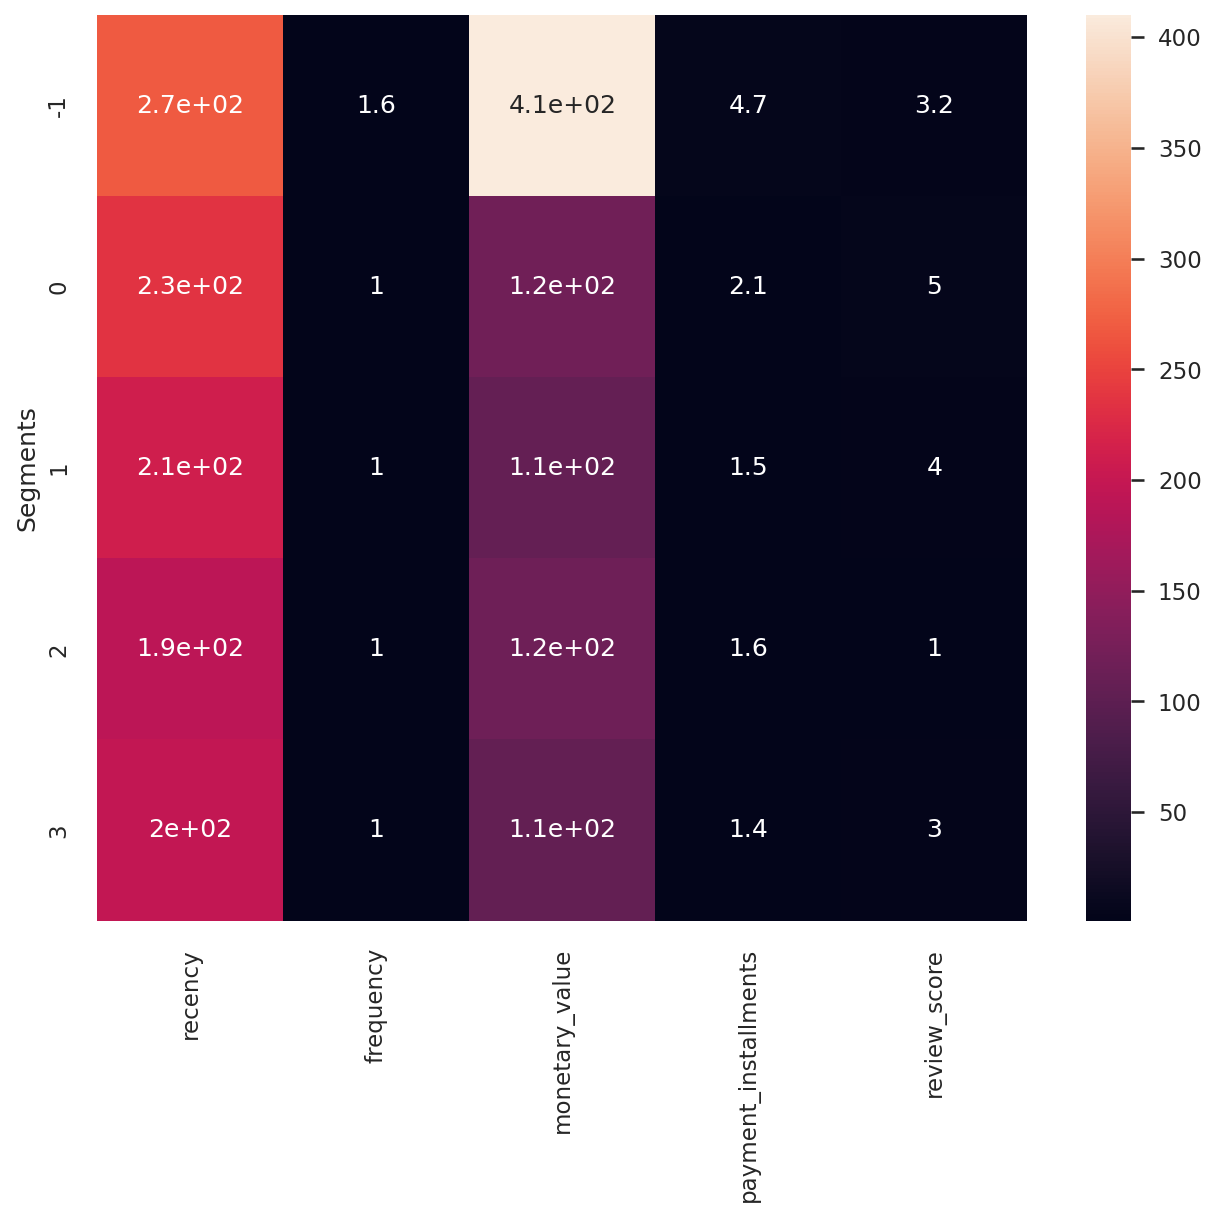

In [81]:
plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(df_segm_analysis, annot=True)


## Un peu de commentaire
Segmentation par DBSCAN, nous donne 5 segments. Le premier segment (segment -1) nous indique la presence de 15326 valeurs abérantes. 